In [21]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

caco3_molar_mass = 100.0869 # g/mol
carbon_molar_mass = 12.011 # g/mol
seconds_per_day = 86400.

# Generate Paths

In [3]:
file_path = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp'
years = ['1995-1999', '2000-2004', '2005-2009', '2010-2014']
yearmons = ['199501-199912', '200001-200412', '200501-200912', '201001-201412']

diagType1 = 'ocean_cobalt_omip_2d'
diagType2 = 'ocean_cobalt_fdet_100'

vars1 = ['epcalc100','eparag100','epsi100']
vars2 = ['flithdet_100']

In [17]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'

file_prefix_1 = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
files1 = [dot.join([file_prefix_1 + diagType1, yy, v1, 'nc']) for v1 in vars1 for yy in years]

file_prefix_2 = os.path.join(file_path, diagType2, 'ts', 'annual', '5yr/')
files2 = [dot.join([file_prefix_2 + diagType2, yy, v2, 'nc']) for v2 in vars2 for yy in years]

files1.extend(files2)
# print(files1)

# Load Model Data

In [19]:
ds = xr.open_mfdataset(files1, combine='by_coords')

In [20]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [26]:
ds

<xarray.Dataset>
Dimensions:       (nv: 2, time: 20, xh: 720, yh: 576)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * time          (time) object 1995-07-02 12:00:00 ... 2014-07-02 12:00:00
  * xh            (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh            (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Data variables:
    eparag100     (time, yh, xh) float32 dask.array<chunksize=(5, 576, 720), meta=np.ndarray>
    time_bnds     (time, nv) object dask.array<chunksize=(5, 2), meta=np.ndarray>
    average_T1    (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(5,), meta=np.ndarray>
    epcalc100     (time, yh, xh) float32 dask.array<chunksize=(5, 576, 720), meta=np.ndarray>
    epsi100       (time, yh, xh) float32 dask.array<chunksize=(5, 576, 720), meta=np.ndarray>
    flithdet_100  (time, yh, xh) float32 dask.array<chunksize=(5, 576, 720), meta=np.ndarray>
Attributes:
    filename:            ocean_cobalt_omip_2d.1995-1999.epcalc100.nc
    title:               ESM4_historical_D1
    associated_files:    areacello: 19950101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello
    comment:             FMS time averaging, version 3.0, precision=double

# Calculate global totals

In [35]:
ds['fcadet_100'] = ds.eparag100 + ds.epcalc100 #sinking_mole_flux_of_aragonite_expressed_as_carbon_in_sea_water
fcadet_100 = ds.fcadet_100.mean(dim='time') * carbon_molar_mass * 1000 * seconds_per_day

In [28]:
fcadet_calc_100 = (ds.epcalc100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fcadet_calc_100 = fcadet_calc_100 * carbon_molar_mass * seconds_per_day * 365.
print(str(np.round(fcadet_calc_100.values/1e15,2)) + ' Pg C y-1') # units of g C / yr

0.34 Pg C y-1


In [29]:
fcadet_arag_100 = (ds.eparag100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fcadet_arag_100 = fcadet_arag_100 * carbon_molar_mass * seconds_per_day * 365.
print(str(np.round(fcadet_arag_100.values/1e15,2)) + ' Pg C y-1') # units of g C / yr

0.06 Pg C y-1


In [30]:
fcadet_100 = (ds.fcadet_100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fcadet_100 = fcadet_100 * carbon_molar_mass * seconds_per_day * 365.
print('Total calcium carbonate detritus flux at 100 m: ' + str(np.round(fcadet_100.values/1e15,2)) + ' Pg C y-1') # units of g C / yr

Total calcium carbonate detritus flux at 100 m: 0.4 Pg C y-1


In [31]:
fsidet_100 = (ds.epsi100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
fsidet_100 = fsidet_100 * seconds_per_day * 365.
print('Silicon detritus flux at 100 m: ' + str(np.round(fsidet_100.values/1e12,2)) + ' Tmol y-1') # units of g C / yr

Silicon detritus flux at 100 m: 86.96 Tmol y-1


In [32]:
flithdet_100 = (ds.flithdet_100 * grid.areacello).sum(dim=['xh','yh']).mean(dim='time')
flithdet_100 = flithdet_100 * seconds_per_day * 365.
print('Lithogenic detritus flux at 100 m: ' + str(np.round(flithdet_100.values/1e15,2)) + ' Pmol y-1') # units of g C / yr

Lithogenic detritus flux at 100 m: 0.8 Pmol y-1


# Plot

Text(0.5, 1.0, 'Total CaCO3 detritus at 100 m')

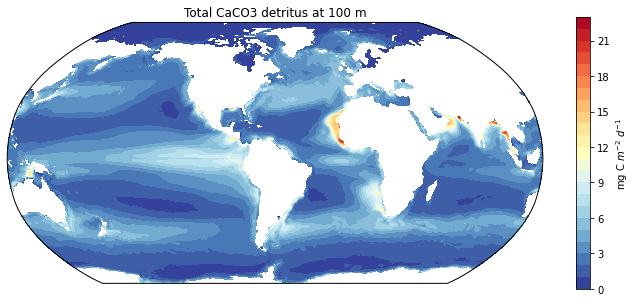

In [43]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300))

field = fcadet_100
cmin = 0; cmax = 24; cint = 1
levels=np.arange(cmin,cmax,cint)

cs=ax.contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r')

lb=plt.colorbar(cs, extend='both')
lb.set_label('mg C $m^{-2}$ $d^{-1}$')
plt.title('Total CaCO3 detritus at 100 m')

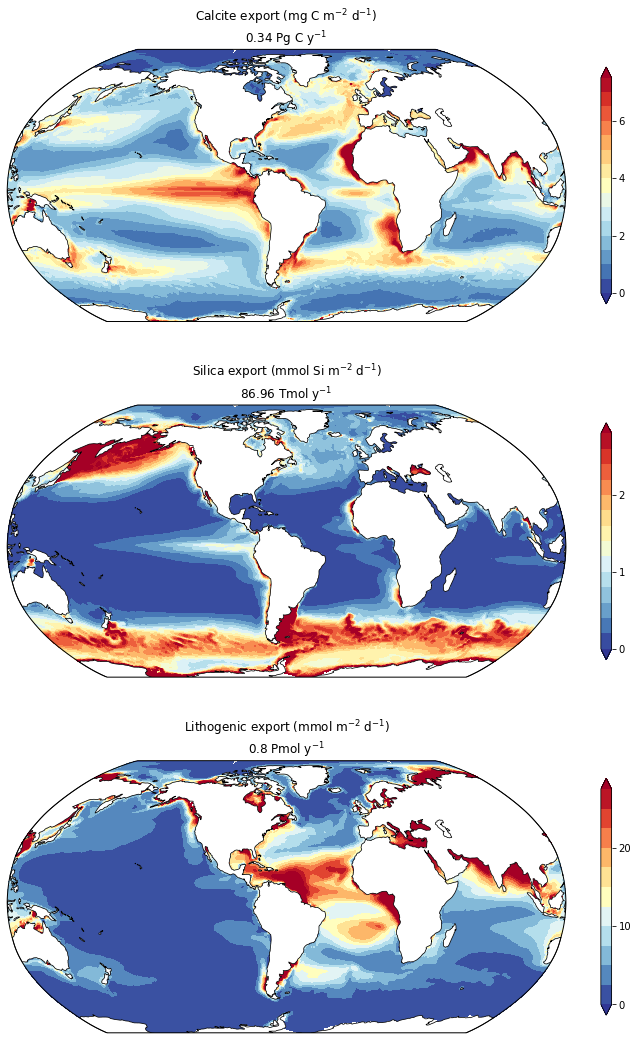

In [44]:
fig=plt.figure(figsize=(10,15))
gs=gridspec.GridSpec(3,1)

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Calcite export                                                          #
###########################################################################
cmin = 0; cmax = 8; cint = 0.5
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds.epcalc100.mean(dim='time') * carbon_molar_mass * seconds_per_day * 1000.
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Calcite export (mg C m$^{-2}$ d$^{-1}$)\n'+str(np.round(fcadet_calc_100.values/1e15,2)) + ' Pg C y$^{-1}$', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,2,4,6,8], shrink=0.75)


###########################################################################
# Silica export                                                           #
###########################################################################
cmin = 0; cmax = 3; cint = 0.2;
levels=np.arange(cmin,cmax,cint)

i=1
ax[i]=plt.subplot(gs[i,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds.epsi100.mean(dim='time') * seconds_per_day * 1000.
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Silica export (mmol Si m$^{-2}$ d$^{-1}$)\n'+str(np.round(fsidet_100.values/1e12,2)) + ' Tmol y$^{-1}$', fontsize=fs)


cbar=plt.colorbar(cs[i], ticks=[0,1,2,3,4], shrink=0.75)


###########################################################################
# Lithogenic export                                                       #
###########################################################################
cmin = 0; cmax = 30; cint = 2.5;
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[i,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds.flithdet_100.mean(dim='time') * seconds_per_day * 1000.
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdYlBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Lithogenic export (mmol m$^{-2}$ d$^{-1}$)\n'+str(np.round(flithdet_100.values/1e15,2)) + ' Pmol y$^{-1}$', fontsize=fs)


cbar=plt.colorbar(cs[i], ticks=[0,10,20,30], shrink=0.75)

plt.tight_layout()
fname = 'Fig16_Mineral_export'
plt.savefig('../plots/'+fname+'.png', dpi=300, bbox_inches='tight')